In [1]:
%matplotlib widget
from typing import Callable, Tuple
import functools
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, sub_sample_data, eval_func_on_grid, lognormpdf

In [2]:
# Set up Satellite Dynamics Problem

X_NAMES = [r'$q_1$', r'$q_2$', r'$q_3$', r'$q_4$', r'$\omega_1$', r'$\omega_2$', r'$\omega_3$']
K1_TRUE = 5
K2_TRUE = 5
J12_TRUE = 1.2


def x0(q1=-0.6, q2=0.4, q3=-0.2, w1=1.2, w2=-1.5, w3=0.2):
    return np.array([q1, q2, q3, np.sqrt(1-q1**2-q2**2-q3**2), w1, w2, w3])


print(f"x0 = {np.array2string(x0(), precision=3, floatmode='fixed')}")


def M(q1, q2, q3, q4):
    return 0.5 * (q4 * np.eye(3) + np.array([[0, -q3, q2],
                                            [q3, 0, -q1],
                                             [-q2, q1, 0]]))


print(f'\nM(x0) =\n{M(*x0()[:4])}')


def tau(k1, q1, q2, q3, q4, k2, w1, w2, w3):
    return -k1 * M(q1, q2, q3, q4).T @ np.array([[q1],
                                                 [q2],
                                                 [q3]]) \
        - k2 * np.clip(np.array([[w1],
                                 [w2],
                                 [w3]]),
                       -1, 1)


print(f'\nTrue tau(x0) =\n{tau(K1_TRUE, *x0()[:4], K2_TRUE, *x0()[4:])}')


def J(J12):
    return np.array([[20, J12, 0.9],
                     [J12, 17, 1.4],
                     [0.9, 1.4, 15]])


print(f'\nTrue J =\n{J(J12_TRUE)}')


def f(t, x, k1, k2, J12):
    q1, q2, q3, q4, w1, w2, w3 = x
    [[tau1], [tau2], [tau3]] = tau(k1, q1, q2, q3, q4, k2, w1, w2, w3)
    q_dot = 0.5 * np.array([[q4*w1 - q3*w2 + q2*w3],
                            [q3*w1 + q4*w2 - q1*w3],
                            [-q2*w1 + q1*w2 + q4*w3],
                            [-q1*w1 - q2*w2 - q3*w3]])

    J_ = J(J12)
    [[J11, J12, J13], [J21, J22, J23], [J31, J32, J33]] = J_
    w_dot = np.linalg.inv(J_) @ np.array([
        [-(w2*(J31*w1 + J32*w2 + J33*w3) - w3*(J21*w1 + J22*w2 + J23*w3)) + tau1],
        [-(w3*(J11*w1 + J12*w2 + J13*w3) - w1*(J31*w1 + J32*w2 + J33*w3)) + tau2],
        [-(w1*(J21*w1 + J22*w2 + J23*w3) - w2*(J11*w1 + J12*w2 + J13*w3)) + tau3]])

    return np.vstack((q_dot, w_dot)).flatten()  # so in same format as x0


def f_true(t, x):
    return f(t, x, K1_TRUE, K2_TRUE, J12_TRUE)


print(f"\nf_true(0, x0) = {np.array2string(f_true(0, x0()), precision=3, floatmode='fixed')}")


T0 = 0
Tend = 60
Tsteps = 50

# true output
Tsteps_multiplier = 100  # increase the fidelity of the true solution
Teval = np.linspace(T0, Tend, Tsteps*Tsteps_multiplier)
sol_true = scipy.integrate.solve_ivp(
    fun=f_true, t_span=(T0, Tend), y0=x0(), method='RK45', t_eval=Teval)
Tspan_true = sol_true.t
x_true = sol_true.y  # 7(dims) x Tsteps(5000)

# sensor output, low fiedlity and corrupted by noise
Teval = np.linspace(T0, Tend, Tsteps)
sol_sens = scipy.integrate.solve_ivp(
    fun=f_true, t_span=(T0, Tend), y0=x0(), method='RK45', t_eval=Teval)
Tspan_sens = sol_sens.t
x_sens = sol_sens.y + np.random.normal(0, 0.05, (sol_sens.y.shape))

# set multiplier to 1 and run this to check that the solutions would be the same if run twice
# assert np.allclose(x_true,sol_sens.y), "x_true != sol_sens.y"

x0 = [-0.600  0.400 -0.200  0.663  1.200 -1.500  0.200]

M(x0) =
[[ 0.33166248  0.1         0.2       ]
 [-0.1         0.33166248  0.3       ]
 [-0.2        -0.3         0.33166248]]

True tau(x0) =
[[-4.00501256]
 [ 4.33667504]
 [-0.66833752]]

True J =
[[20.   1.2  0.9]
 [ 1.2 17.   1.4]
 [ 0.9  1.4 15. ]]

f_true(0, x0) = [ 0.288 -0.557  0.276  0.680 -0.283  0.183 -0.380]


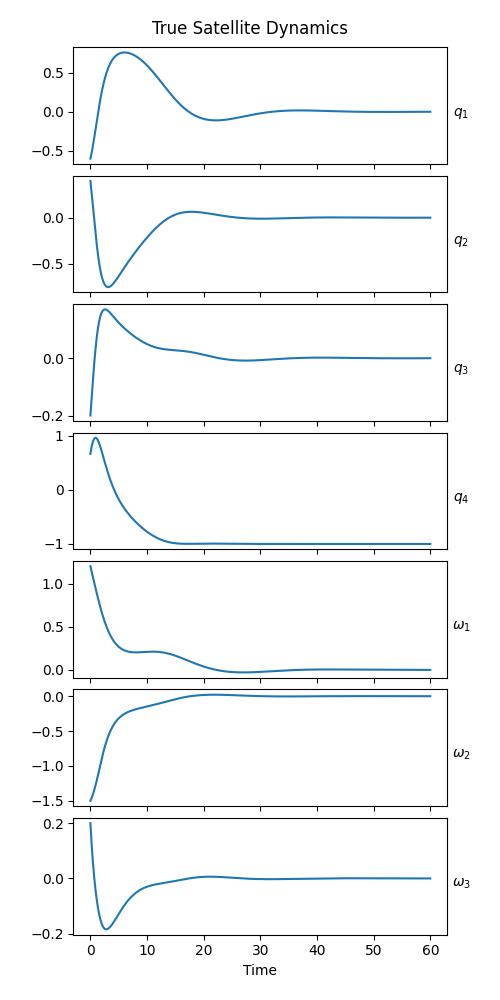

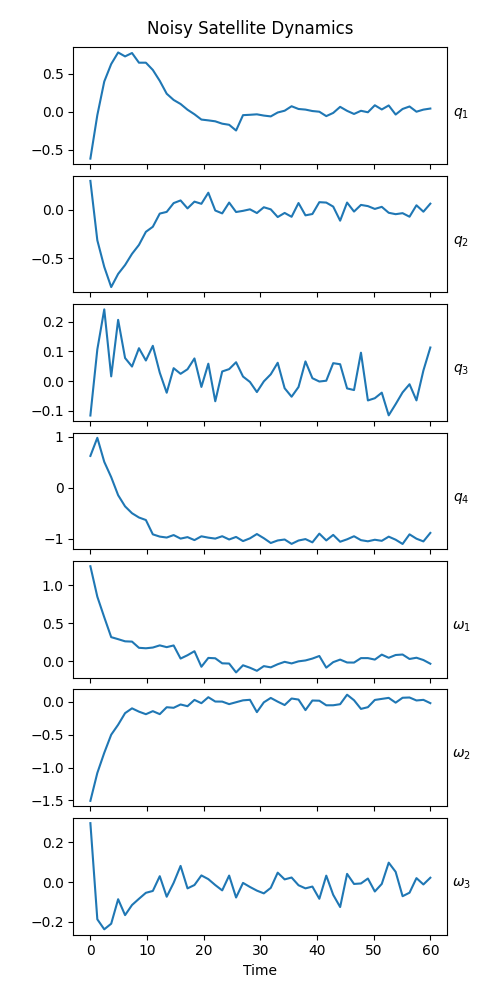

In [3]:
# generate noisy data

def plot_ode(fignum, t, x, x_names, title):
    plt.close(fignum)
    fig, axs = plt.subplots(x.shape[0], 1, sharex=True, num=fignum, figsize=(5, 10))
    fig.tight_layout(pad=3)
    fig.suptitle(title)
    for i, (ax, x_name) in enumerate(zip(axs, x_names)):
        ax.plot(t, x[i, :])
        ax.set_ylabel(x_name, rotation=0, labelpad=10)
        ax.yaxis.set_label_position("right")
    axs[-1].set_xlabel('Time')
    fig.subplots_adjust(hspace=0.1)
    fig.savefig(f'figs/{title}.svg')
    plt.show()
    return fignum + 1


fignum = 1
fignum = plot_ode(fignum, Tspan_true, x_true, X_NAMES, "True Satellite Dynamics")
fignum = plot_ode(fignum, Tspan_sens, x_sens, X_NAMES, "Noisy Satellite Dynamics")